<br>

# An Awesome Movie Recommender

<br>


##### The datasets files were taken from the following sources:
* Movie Lens (small) dataset : https://grouplens.org/datasets/movielens/
* IMDb dataset : https://www.imdb.com/interfaces/

<br>

### LIBRAIRIES


In [1]:
# Regular librairies
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.getipython import get_ipython

# Machine learning - collaborative
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV

# Machine learning - content
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### PRE-PROCESSING

In [2]:


# Set absolute path of the current script
#current_file_path = os.path.realpath(__file__)
current_file_path = get_ipython().starting_dir
current_dir = os.path.dirname(current_file_path)

## COLLABORATIVE FILTERING ##
ml_latest_small_dir = os.path.join(current_dir, 'data', 'ml-latest-small')
pkl_dir = os.path.join(current_dir, 'data', 'pkl')

# Load datasets into a DataFrame
df_ml_movies = pd.read_csv(os.path.join(ml_latest_small_dir, 'movies.csv'))
df_ml_ratings = pd.read_csv(os.path.join(ml_latest_small_dir, 'ratings.csv'))
df_ml_links = pd.read_csv(os.path.join(ml_latest_small_dir, 'links.csv'))

# Merge dataframes on movieId
df_movie_lens = df_ml_movies.merge(df_ml_links, how='inner', on='movieId')
df_movie_lens = df_ml_ratings.merge(df_movie_lens, how='inner', on='movieId')

# Drop NaNs
df_movie_lens = df_movie_lens.dropna(subset=['tmdbId'])

## Pickle files ##
best_params_file = os.path.join(pkl_dir, "best_params.pkl")
data_file = os.path.join(pkl_dir, "data.pkl")
algo_file = os.path.join(pkl_dir, "algo.pkl")



## CONTENT-BASED FILTERING ##

# Load datasets into a DataFrame
data_dir_imdb = os.path.join(current_dir, 'data', 'IMDb')
data_dir_ml20m = os.path.join(current_dir, 'data', 'ml-20m')

df_movies = pd.read_csv(os.path.join(data_dir_imdb, 'df_movies.csv'))
df_ml_genome_scores = pd.read_csv(os.path.join(data_dir_ml20m, 'genome-scores.csv.gz'))
df_ml_genome_tags = pd.read_csv(os.path.join(data_dir_ml20m, 'genome-tags.csv'))

# taking care of NaN and data types
df_movies['year']=df_movies['year'].fillna(df_movies['startYear'].astype('int'))
df_movies['year']=df_movies['year'].astype('int')
df_movies['title_year']=df_movies['title_ml']+' ('+df_movies['year'].astype('str')+')'
df_movies = df_movies[['movieId', 'title_ml','year','genres_ml', 'title_year',
                       'averageRating','numVotes','genres_imdb','tconst']]
df_movies = df_movies.rename(columns={'title_year': 'title'})

df_ml_genome = df_ml_genome_scores.merge(df_ml_genome_tags, how='inner', on='tagId')

# Defining a threshold to retain ML tags relevance
threshold = 0.8
df_relevant = df_ml_genome[df_ml_genome['relevance'] > threshold]

# Transpose retained ML tags into one line per movie
df_grouped_by_tags = pd.DataFrame(df_relevant.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
df_ml_relevant_tags=pd.merge(df_movies,df_grouped_by_tags, on='movieId', how='left')

# Taking care of NaN and 'no genre'
df_ml_relevant_tags['tag']=df_ml_relevant_tags['tag'].fillna('')
df_ml_relevant_tags['genres_imdb']=df_ml_relevant_tags['genres_imdb'].fillna('')
df_ml_relevant_tags['genres_ml']=df_ml_relevant_tags['genres_ml'].replace(to_replace = '(no genres listed)', value = '')

# Joining tags and genres
df_ml_relevant_tags['tag']=df_ml_relevant_tags['genres_ml'].replace('|', ' ', regex=False)+' '+df_ml_relevant_tags['tag']+' '+df_ml_relevant_tags['genres_imdb'].str.replace(',', ' ')
df_ml_relevant_tags['tag']=df_ml_relevant_tags['tag'].str.lower()
# Joining TMDB Id
df_ml_relevant_tags = df_ml_relevant_tags.merge(df_ml_links)


## Pickle files ##
sim_movie_file = os.path.join(pkl_dir, "similar_movie.pkl")

### DATA EXPLORATION

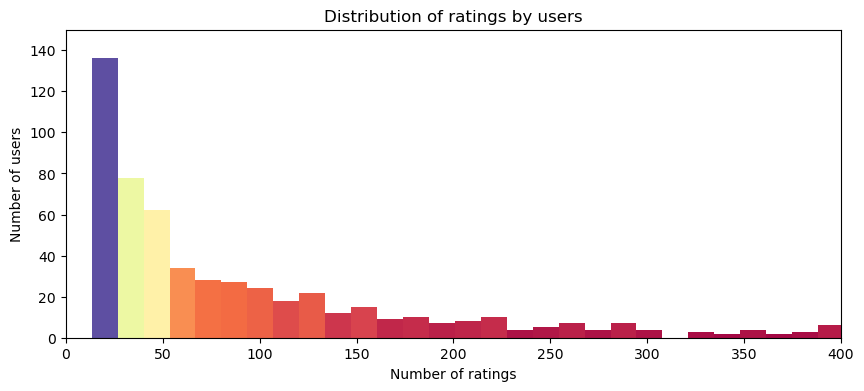

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: userId, dtype: float64


In [3]:

# Distribution of ratings by users
nb_ratings_by_user = df_ml_ratings['userId'].value_counts()

counts, bins = np.histogram(nb_ratings_by_user, bins=200) # Compute the histogram
cmap = plt.cm.Spectral
norm = plt.Normalize(counts.min(), counts.max()) # Normalize bar height

f,ax = plt.subplots(1,1,figsize=(10,4))
for count, x in zip(counts, bins[:-1]):
    plt.bar(x, count, width=bins[1]-bins[0], color=cmap(norm(count)))
plt.xlim(0, 400)
plt.ylim(0, 150)
plt.title('Distribution of ratings by users')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

print(nb_ratings_by_user.describe())

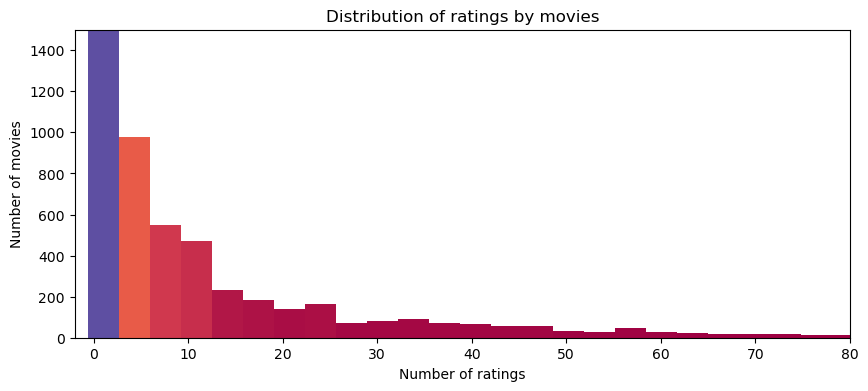

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: movieId, dtype: float64


In [4]:

# Distribution of ratings by movies
nb_ratings_by_movie = df_ml_ratings['movieId'].value_counts()

counts, bins = np.histogram(nb_ratings_by_movie, bins=100) # Compute the histogram
cmap = plt.cm.Spectral
norm = plt.Normalize(counts.min(), counts.max()) # Normalize bar height

f,ax = plt.subplots(1,1,figsize=(10,4))
for count, x in zip(counts, bins[:-1]):
    plt.bar(x, count, width=bins[1]-bins[0], color=cmap(norm(count)))
plt.xlim(-2, 80)
plt.ylim(0, 1500)
plt.title('Distribution of ratings by movies')
plt.xlabel('Number of ratings')
plt.ylabel('Number of movies')
plt.show()

print(nb_ratings_by_movie.describe())

### MODEL BUILDING

In [5]:

### COLLABORATIVE FILTERING

# Parameters tuning

def model_tuning(best_params_file, data):
    
    # Check if best_params file exists
    if os.path.exists(best_params_file):
        
        with open(best_params_file, "rb") as f:
            best_params = pickle.load(f)
    else:
        
        param_grid = {'n_factors': [50, 100, 150],
                      'n_epochs': [10, 20, 30], 
                      'lr_all': [0.002, 0.005, 0.01],
                      'reg_all':[0.05, 0.1, 0.2]}
        
        gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
        gs.fit(data)
    
        # Tuned SVD with best params from GridSearchCV
        best_params = gs.best_params["rmse"]
    
        # Save best_params to the file
        with open(best_params_file, "wb") as f:
            pickle.dump(best_params, f)
    
    # Create and fit a trainset out of the full data dataset
    algo = SVD(n_epochs=best_params['n_epochs'], 
               lr_all=best_params['lr_all'], 
               reg_all=best_params['reg_all'], 
               n_factors=best_params['n_factors'],
               random_state=42)
    
    algo2 = SVD(random_state=42)

    return algo2
    

# Model

def hey_honey_what_do_we_watch_tonight(user_id, top_n, df_movie_lens):
    
    # Convert data into Surprise Dataset (pivot table)
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df_movie_lens[['userId','tmdbId','rating']], reader)
    
    # Surprise trainset object
    trainset = data.build_full_trainset()
    
    # Fit model
    model = model_tuning(best_params_file, data)
    model.fit(trainset)
    
    # List of movies already rated
    rated_movies = [(item_id, rating) for (item_id, rating) in trainset.ur[user_id]]
    rated_movies = sorted(rated_movies, key=lambda x: x[1], reverse=True)

    # List of movies not rated yet
    not_rated_movies = [item_id for item_id in trainset.all_items() if item_id not in set(item_id for (item_id, _) in trainset.ur[user_id])]

    # Predictions
    predictions = [model.predict(user_id, item_id) for item_id in not_rated_movies]
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)

    # Get top n recommendations
    recommendations = [{'tmdbId': pred.iid, 'title': df_movie_lens.loc[df_movie_lens['tmdbId'] == pred.iid, 'title'].iloc[0], 'predicted_rating': pred.est} for pred in sorted_predictions[:top_n]]

    # Create a dataframe with the top_n recommendations
    df_top_n_recommendations = pd.DataFrame(recommendations)

    # Create a dataframe with the rated movies
    #df_rated_movies = pd.DataFrame([{'tmdbId': item_id, 'title': df_movie_lens.loc[df_movie_lens['tmdbId'] == trainset.to_raw_iid(item_id), 'title'].iloc[0], 'rating': rating} for (item_id, rating) in rated_movies])
    #df_rated_movies = df_rated_movies[:top_n]
    # Create a dataframe with the rated movies
    df_rated_movies = pd.DataFrame([{'tmdbId': model.trainset.to_raw_iid(item_id), 'title': df_movie_lens.loc[df_movie_lens['tmdbId'] == model.trainset.to_raw_iid(item_id), 'title'].iloc[0], 'rating': rating} for (item_id, rating) in rated_movies])
    df_rated_movies = df_rated_movies[:top_n]

    
    return df_top_n_recommendations, df_rated_movies



In [6]:

### CONTENT-BASED FILTERING ###

# Save or load the similar matrix using pickle
def get_similar_matrix(tag_data, pickle_file):
    if os.path.exists(pickle_file):
        with open(pickle_file, "rb") as file:
            sim_matrix = pickle.load(file)
    else:
        vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), stop_words='english', max_features=5000)
        tfidf_tag_matrix = vectorizer.fit_transform(tag_data)
        sim_matrix = cosine_similarity(tfidf_tag_matrix, tfidf_tag_matrix)
        
        with open(pickle_file, "wb") as file:
            pickle.dump(sim_matrix, file)

    return sim_matrix


def content_recommendations(tmdbId, sim_matrix, df_ml_relevant_tags, top_n):
    indices = pd.Series(df_ml_relevant_tags.index, index=df_ml_relevant_tags['tmdbId'])
    index = indices[tmdbId]
    sim_scores = list(enumerate(sim_matrix[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    movies = df_ml_relevant_tags.iloc[movie_indices][['title', 'averageRating', 'numVotes', 'tmdbId']]
    movies = movies[:top_n]
    return movies


In [7]:
# RUN

df_top_n_recommendations, df_rated_movies = hey_honey_what_do_we_watch_tonight(3, 10, df_movie_lens)
similar_movie = get_similar_matrix(df_ml_relevant_tags['tag'].values, sim_movie_file)
selected_movie_id = df_top_n_recommendations.loc[4, 'tmdbId']
content_based_recommendations = content_recommendations(selected_movie_id, similar_movie, df_ml_relevant_tags, 10)

In [8]:
df_rated_movies

,tmdbId,title,rating
0,11.0,Star Wars: Episode IV - A New Hope (1977),5.0
1,13.0,Forrest Gump (1994),5.0
2,424.0,Schindler's List (1993),5.0
3,1891.0,Star Wars: Episode V - The Empire Strikes Back...,5.0
4,1892.0,Star Wars: Episode VI - Return of the Jedi (1983),5.0
5,348.0,Alien (1979),5.0
6,105.0,Back to the Future (1985),5.0
7,497.0,"Green Mile, The (1999)",5.0
8,98.0,Gladiator (2000),5.0
9,278.0,"Shawshank Redemption, The (1994)",5.0


In [9]:
df_top_n_recommendations

,tmdbId,title,predicted_rating
0,694,"Shining, The (1980)",3.709823
1,510,One Flew Over the Cuckoo's Nest (1975),3.651717
2,603,"Matrix, The (1999)",3.539030
3,550,Fight Club (1999),3.527363
4,9606,Metropolis (2001),3.518264
5,769,Goodfellas (1990),3.496892
6,829,Chinatown (1974),3.483331
7,9490,Half Baked (1998),3.462438
8,9430,Go (1999),3.456050
9,1585,It's a Wonderful Life (1946),3.453232


In [10]:
content_based_recommendations

,title,averageRating,numVotes,tmdbId
5994,Steamboy (Suchîmubôi) (2004),6.8,17997,8953.0
2279,Robot Carnival (Roboto kânibauru) (1987),6.8,2632,33441.0
1853,Nausicaä of the Valley of the Wind (Kaze no ta...,8.0,171335,81.0
5865,"Animatrix, The (2003)",7.3,79305,55931.0
2313,Akira (1988),8.0,189448,149.0
3610,Ghost in the Shell (Kôkaku kidôtai) (1995),7.9,145505,9323.0
8513,"Book of Life, The (2014)",7.2,73091,228326.0
6040,Robots (2005),6.4,150546,9928.0
3626,Memories (Memorîzu) (1995),7.5,18958,42994.0
7257,WALL·E (2008),8.4,1122433,10681.0
